In [76]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/processed_data/data_1.csv')

In [3]:
df.head()

,CRASH_DATETIME,CASUALTY,FRONT_OR_BACK_ENDED,GOING_STRAIGHT_AHEAD,IN_INTERSECTION,TRUCK_TAXI_BIKE,CLUSTER
0,07/01/2012 10:40,0,0,0,0,0,45
1,07/01/2012 12:18,0,0,0,0,1,25
2,07/01/2012 18:00,0,0,0,0,0,69
3,07/01/2012 19:30,0,0,0,0,0,69
4,07/01/2012 20:00,0,0,0,0,1,58


# Preprocessing

In [4]:
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])

In [5]:
df = df.set_index('CRASH_DATETIME').resample('W')[['CASUALTY']].sum()

# Unit Root Test


### Augmented Dickey-Fuller Test

- $H_0$: not stationary
- $H_A$: stationary

A small $p$-value would give us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.

In [6]:
adfuller(df['CASUALTY'])

(-3.149419061343534,
 0.0231056237174973,
 4,
 488,
 {'1%': -3.4438213751870337,
  '5%': -2.867480869596464,
  '10%': -2.5699342544006987},
 3942.2859543506415)

In [17]:
adfuller(df['CASUALTY'].diff().dropna())

(-15.614277598750594,
 1.764032047438213e-28,
 3,
 488,
 {'1%': -3.4438213751870337,
  '5%': -2.867480869596464,
  '10%': -2.5699342544006987},
 3939.0775582817014)

# Feature Engineering

In [69]:
df["first_diff"] = df['CASUALTY'].diff()

df['covid'] = df.index.to_series().between('2020-03-01', '2020-07-01').astype(int)

In [70]:
y_train, y_test = train_test_split(df['first_diff'], test_size=0.05, shuffle=False)
y_train = y_train.iloc[1:]

# Model: ARIMA

In [71]:
# Starting AIC, p, and q.
best_aic = float('inf')
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})... ', end=' ')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 0, q))
            
            
            # Fit ARIMA model.
            model = arima.fit(method='innovations_mle')

            # Print out AIC for ARIMA(p, 1, q) model.
            print('success... ', end=' ')
            print(f'AIC = {round(model.aic, 2)}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)...  success...  AIC = 4045.07
Attempting ARIMA(0, 1, 1)...  success...  AIC = 3941.22
Attempting ARIMA(0, 1, 2)...  success...  AIC = 3942.38
Attempting ARIMA(0, 1, 3)...  success...  AIC = 3943.39
Attempting ARIMA(0, 1, 4)...  success...  AIC = 3944.45
Attempting ARIMA(1, 1, 0)...  success...  AIC = 3969.3
Attempting ARIMA(1, 1, 1)...  success...  AIC = 3942.19
Attempting ARIMA(1, 1, 2)...  success...  AIC = 3944.54
Attempting ARIMA(1, 1, 3)...  success...  AIC = 3931.42
Attempting ARIMA(1, 1, 4)...  success...  AIC = 3945.82
Attempting ARIMA(2, 1, 0)...  success...  AIC = 3953.32
Attempting ARIMA(2, 1, 1)...  success...  AIC = 3942.67
Attempting ARIMA(2, 1, 2)...  success...  AIC = 3931.43
Attempting ARIMA(2, 1, 3)...  success...  AIC = 3941.74
Attempting ARIMA(2, 1, 4)...  success...  AIC = 3947.37
Attempting ARIMA(3, 1, 0)...  success...  AIC = 3951.08
Attempting ARIMA(3, 1, 1)...  success...  AIC = 3932.75
Attempting ARIMA(3, 1, 2)...  success...  AIC = 3

In [72]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(1, 0, 3))

# Fit ARIMA model.
model = arima.fit(method='innovations_mle')

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end=y_test.index[-1])

In [73]:
y_train_ = y_train.reindex(df.index[df.index <= y_train.index[-1]], fill_value=0).cumsum() + df.loc[df.index[0], 'CASUALTY']
y_test_ = y_test.cumsum() + y_train_.iloc[-1]
preds_ = preds.cumsum() + y_train_.iloc[-1]

# Plot results

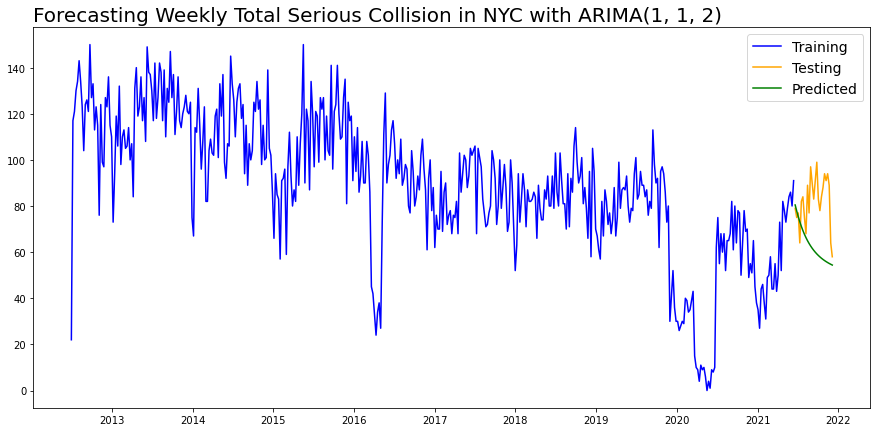

In [74]:
# Plot data.
plt.figure(figsize=(15,7))
plt.plot(y_train_, color = 'blue', label='Training')
plt.plot(y_test_, color = 'orange', label='Testing')
plt.plot(y_test_.index, preds_, color = 'green', label='Predicted')
plt.title(label = 'Forecasting Weekly Total Serious Collision in NYC with ARIMA(1, 1, 2)', fontsize=20, loc='left')
plt.legend(fontsize=14);